# Table of contents

**1. Installation & setup**
   - Install bombcell package
   - Import libraries and set up paths
   - Configure parameters for both quality metrics and ephys properties

**2. Quality metrics analysis**
   - Run bombcell quality control pipeline
   - Classify units (good/MUA/noise/non-somatic)
   - Explore quality metrics results
   - Use interactive GUI for manual validation
   - Fine-tune classification parameters

**3. Ephys properties & cell classification** 
   - Compute electrophysiological properties (firing patterns, waveform features, etc.)
   - Classify cell types (cortical: pyramidal/interneurons, striatal: MSN/FSI/UIN)
   - Generate classification plots and results

---

# 1. Installation & setup

#### Install bombcell

To install the latest stable version:
```bash
conda create -n bombcell python=3.11
conda activate bombcell
pip install uv
uv pip install bombcell # you could do `pip install .`, but uv is much quicker!
```
To install the dev version (with the latest updates): 
```bash
conda create -n bombcell python=3.11
conda activate bombcell
git clone https://github.com/Julie-Fabre/bombcell.git
cd bombcell/pyBombCell
pip install uv
uv pip install -e .
```

#### Import libraries

In [2]:
import os, sys
from pathlib import Path
from pprint import pprint 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

import bombcell as bc

✅ ipywidgets available - interactive GUI ready


In [2]:
# Optional

# # Add bombcell to Python path if NOT installed with pip
# # If notebook is running in bombcell repo:
# demo_dir = Path(os.getcwd())
# pyBombCell_dir = demo_dir.parent
# # Else:
# # pyBombCell_dir = "path/to/bombcell/repository/root"
# sys.path.append(str(pyBombCell_dir))

#### Define paths

In [7]:
# Replace with your kilosort directory
ks_dir = "/home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4"

# Set bombcell's output directory
save_path = Path(ks_dir) / "bombcell"

print(f"Using kilosort directory: {ks_dir}")

Using kilosort directory: /home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4


# Section 1: Quality Metrics

In [8]:
## For Neuropixels probes, provide raw and meta files
## Leave 'None' if no raw data. Ideally, your raw data is common-average-referenced and
# the channels are temporally aligned to each other (this can be done with CatGT)
raw_file_path =  "/home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/20250411_4423_C1_g0_tcat.imec0.ap.bin" #None#"/home/julie/Dropbox/Example datatsets/JF093_2023-03-09_site1/site1/2023-03-09_JF093_g0_t0_bc_decompressed.imec0.ap.bin" # ks_dir
meta_file_path = "/home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/20250411_4423_C1_g0_tcat.imec0.ap.meta" #None#"/home/julie/Dropbox/Example datatsets/JF093_2023-03-09_site1/site1/2023-03-09_JF093_g0_t0_bc_decompressed.imec0.ap.bin"None#"/home/julie/Dropbox/Example datatsets/JF093_2023-03-09_site1/site1/2023-03-09_JF093_g0_t0.imec0.ap.meta"
## Get default parameters - we will see later in the notebook how to assess and fine-tune these
param = bc.get_default_parameters(ks_dir, 
                                  raw_file=raw_file_path,
                                  meta_file=meta_file_path,
                                  kilosort_version=4)

print("Bombcell parameters:")
pprint(param)

Bombcell parameters:
{'computeDistanceMetrics': False,
 'computeDrift': False,
 'computeSpatialDecay': True,
 'computeTimeChunks': False,
 'decompress_data': False,
 'deltaTimeChunk': 360,
 'detrendForUnitMatch': False,
 'detrendWaveform': True,
 'driftBinSize': 60,
 'duplicateSpikeWindow_s': 3.4e-05,
 'ephysKilosortPath': '/home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4',
 'ephys_meta_file': '/home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/20250411_4423_C1_g0_tcat.imec0.ap.meta',
 'ephys_sample_rate': 30000,
 'extractRaw': True,
 'gain_to_uV': 0.762939453125,
 'hillOrLlobetMethod': True,
 'isoDmin': 20,
 'lratioMax': 0.3,
 'maxDrift': 100,
 'maxMainPeakToTroughRatio_nonSomatic': 0.8,
 'maxNPeaks': 2,
 'maxNTroughs': 1,
 'maxPeak1ToPeak2Ratio_nonSomatic': 3,
 'maxPercSpikesMissing': 20,
 'maxRPVviolations': 0.1,
 '

##### Optionally, customize parameters (more on this later, below)

In [ ]:
# you might to change:

# 1. classification thresholds like: 
# param["maxRPVviolations"] = 0.1


#  2. or which quality metrics are computed (by default these are not): 
param["computeDistanceMetrics"] = 0
param["computeDrift"] = 0
param["splitGoodAndMua_NonSomatic"] = 0


#  3. how quality metricsa are calculated:
# a. how refractory period window is defined
param["tauR_valuesMin"]= 0.5 / 1000  # minumum refractory period time (s), usually 0.002 s
param["tauR_valuesMax"]= 5 / 1000  # maximum refractory period time (s)
param["tauR_valuesStep"]= 0.5 / 1000  # if tauR_valuesMin and tauR_valuesMax are different, bombcell 
# will calculate refractory period violations from param["tauR_valuesMin"] to param["tauR_valuesMax"] param["tauR_valuesStep"] 
# bins and determine the option window for each unit before calculating the violations. 
        # tauR_valuesStep
#  b. or whether the recording is split into time chunks to detemrine "good" time chunks: 
# param["computeTimeChunks"] = 0
# full list in the wiki or in the bc.get_default_parameters function

🚀 Starting BombCell quality metrics pipeline...
📁 Processing data from: /home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4
Results will be saved to: /home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4/bombcell

Loading ephys data...
Loaded ephys data: 659 units, 3,988,074 spikes

🔍 Extracting raw waveforms...
Loading file /home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4/bombcell/templates._bc_rawWaveforms.npy... Done!
No splits/merges detected

⚙️ Computing quality metrics for 659 units...
   (Progress bar will appear below)


Computing bombcell quality metrics:   0%|          | 0/659 units


Saving GUI visualization data...
GUI visualization data saved to: /home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4/bombcell/for_GUI/gui_data.pkl
   Generated spatial decay fits: 641/659 units
   Generated amplitude fits: 617/659 units

🏷️ Classifying units (good/MUA/noise/non-soma)...

Generating summary plots...


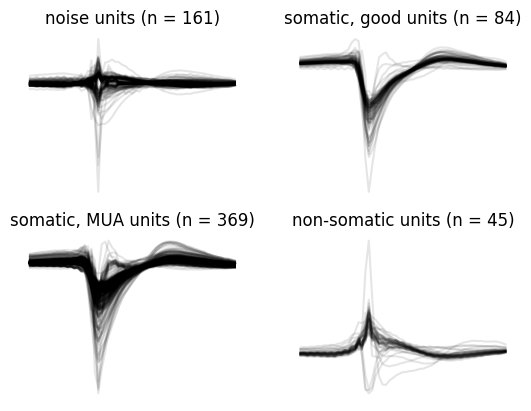

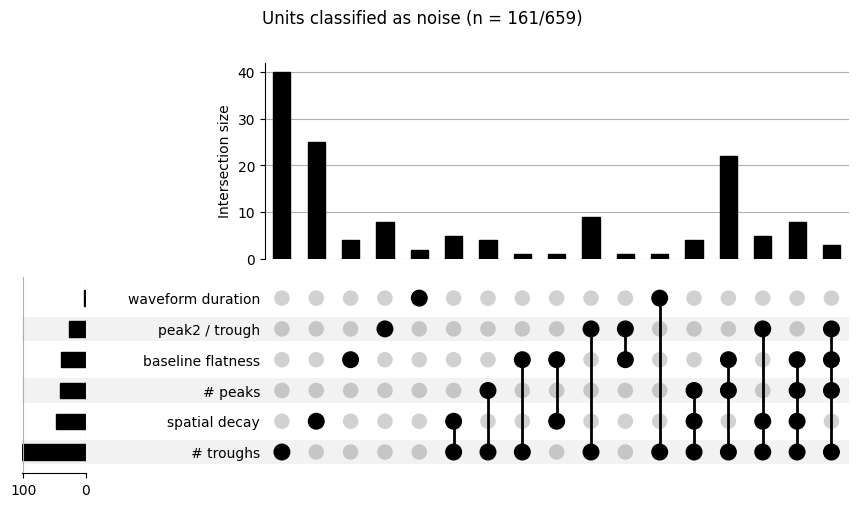

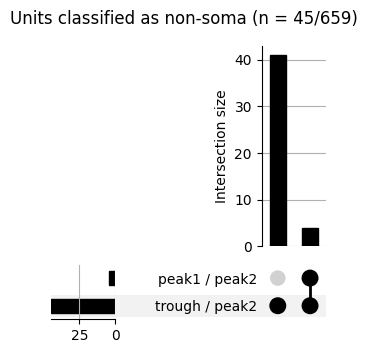

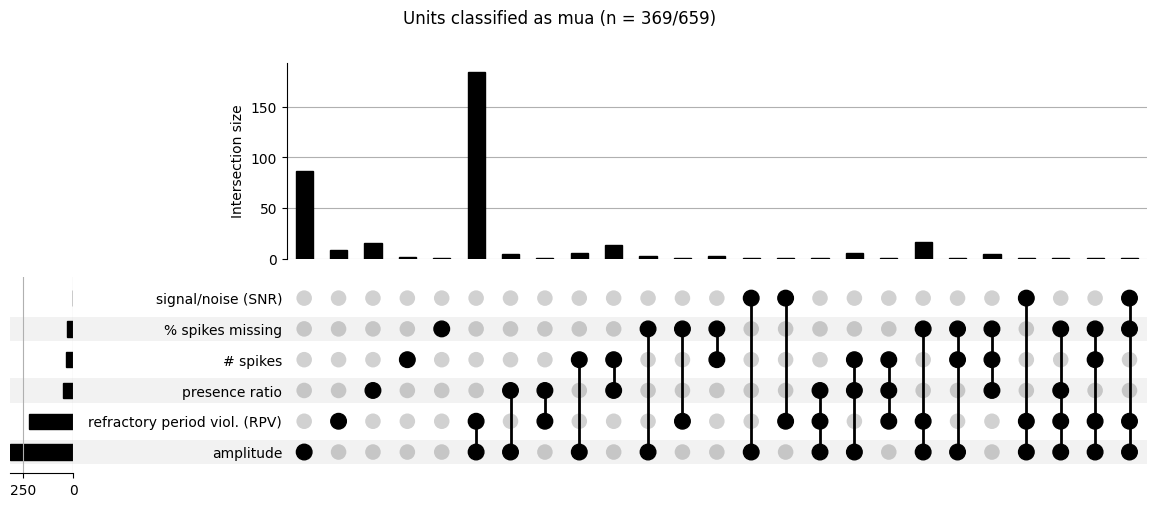

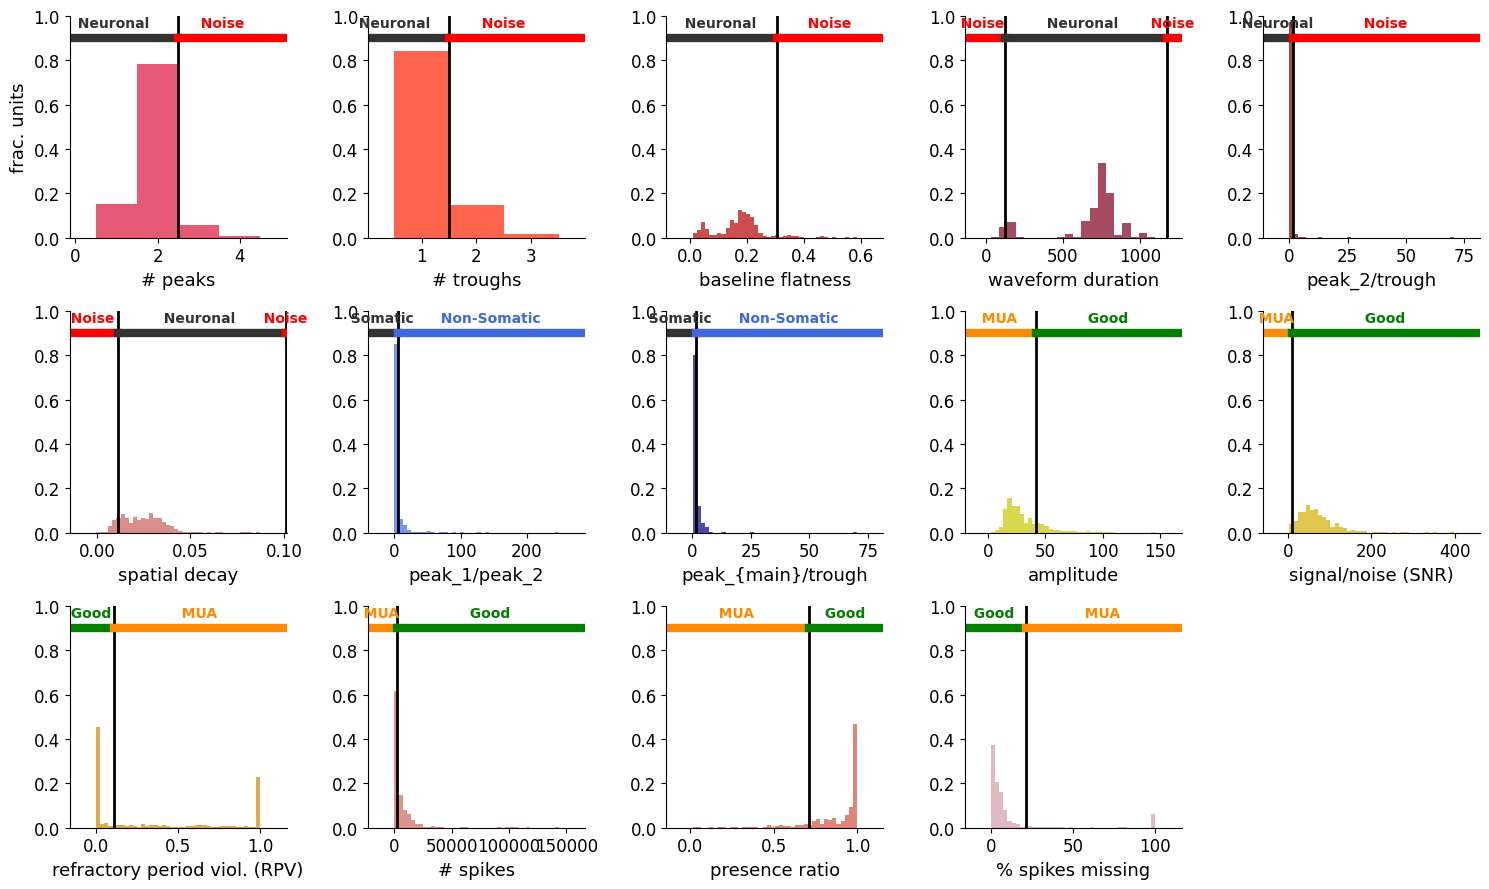


Saving results...
📁 Saving TSV files to Kilosort directory: /home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4
All expected metrics were successfully saved.


In [9]:
(
    quality_metrics,
    param,
    unit_type,
    unit_type_string,
) = bc.run_bombcell(
    ks_dir, save_path, param
)
# Use the output summary plots (below) to see if the 
# quality metric thresholds seem roughly OK for your 
# data (i.e. there isn't one threshold removing all 
# units or a threshold may below that removes none)
# more details on these output plots in the wiki:
# https://github.com/Julie-Fabre/bombcell/wiki/Summary-output-plots

##### How to access bombcell's saved quality metrics
Looking at all quality metric values per unit: 

In [10]:
# quality metric values
quality_metrics_table = pd.DataFrame(quality_metrics)
quality_metrics_table.insert(0, 'Bombcell_unit_type', unit_type_string)
quality_metrics_table

,Bombcell_unit_type,phy_clusterID,nSpikes,nPeaks,nTroughs,waveformDuration_peakTrough,spatialDecaySlope,waveformBaselineFlatness,scndPeakToTroughRatio,mainPeakToTroughRatio,...,maxDriftEstimate,cumDriftEstimate,rawAmplitude,signalToNoiseRatio,isolationDistance,Lratio,silhouetteScore,useTheseTimesStart,useTheseTimesStop,maxChannels
0,MUA,0,3530.0,2.0,1.0,766.666667,0.039761,0.174858,0.255291,0.255291,...,34.587524,345.187622,8.006889,52.291481,NaN,NaN,NaN,0.0074,4265.891433,294
1,NON-SOMA,1,257.0,2.0,1.0,566.666667,0.045575,0.050901,0.331950,2.788892,...,18.664062,92.681519,8.533951,19.244391,NaN,NaN,NaN,0.0074,4265.891433,294
2,NON-SOMA,2,3877.0,1.0,1.0,766.666667,0.040786,0.181772,0.232087,3.842439,...,33.278687,138.354858,7.755369,27.213482,NaN,NaN,NaN,0.0074,4265.891433,294
3,NON-SOMA,3,395.0,1.0,1.0,700.000000,0.020819,0.076359,0.030127,7.343360,...,23.989990,264.958008,32.851219,7.409444,NaN,NaN,NaN,0.0074,4265.891433,296
4,NOISE,4,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,NOISE,654,2444.0,2.0,1.0,700.000000,0.006679,0.195445,0.369775,0.369775,...,0.000000,0.000000,17.264067,76.752589,NaN,NaN,NaN,0.0074,4265.891433,101
655,MUA,655,2224.0,2.0,1.0,633.333333,0.032467,0.174780,0.390186,0.390186,...,14.214966,227.969604,22.836513,92.935289,NaN,NaN,NaN,0.0074,4265.891433,102
656,MUA,656,10784.0,2.0,1.0,733.333333,0.034622,0.218689,0.312206,0.312206,...,10.321533,128.483643,23.704338,55.981467,NaN,NaN,NaN,0.0074,4265.891433,102
657,MUA,657,254.0,2.0,1.0,700.000000,0.040855,0.140442,0.285585,0.285585,...,920.822266,2154.535278,77.670022,58.184171,NaN,NaN,NaN,0.0074,4265.891433,102


In [11]:
# boolean table, if quality metrics pass threshold given parameters
boolean_quality_metrics_table = bc.make_qm_table(
    quality_metrics, param, unit_type_string
)
boolean_quality_metrics_table

,unit_type,Original ID,# peaks,# troughs,waveform duration,baseline flatness,peak2 / trough,spatial decay,% spikes missing,presence ratio,# spikes,fraction RPVs,amplitude,SNR,trough / peak2,peak1 / peak2
0,MUA,0,False,False,False,False,False,False,False,False,False,True,True,False,False,False
1,NON-SOMA,1,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,NON-SOMA,2,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,NON-SOMA,3,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,NOISE,4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,NOISE,654,False,False,False,False,False,True,False,False,False,False,False,False,False,False
655,MUA,655,False,False,False,False,False,False,False,False,False,True,True,False,False,False
656,MUA,656,False,False,False,False,False,False,False,False,False,True,True,False,False,False
657,MUA,657,False,False,False,False,False,False,False,False,True,False,False,False,False,False


Example: get all quality metrics for unit 12

In [12]:
u = 12

units = quality_metrics_table.phy_clusterID
quality_metrics_table.loc[units == u, :]

,Bombcell_unit_type,phy_clusterID,nSpikes,nPeaks,nTroughs,waveformDuration_peakTrough,spatialDecaySlope,waveformBaselineFlatness,scndPeakToTroughRatio,mainPeakToTroughRatio,...,maxDriftEstimate,cumDriftEstimate,rawAmplitude,signalToNoiseRatio,isolationDistance,Lratio,silhouetteScore,useTheseTimesStart,useTheseTimesStop,maxChannels
12,MUA,12,1085.0,2.0,1.0,800.0,0.01994,0.217775,0.291634,0.291634,...,1248.570557,21007.922241,19.41162,34.915456,NaN,NaN,NaN,0.0074,4265.891433,309


#### Look at your data and bombcell's metrics in the minimal GUI

In [13]:
# Launch minimal GUI.
# Ideally, take a look at your units for a few datasets so you can get an idea of which 
# parameters will work best for your purposes. 
gui = bc.unit_quality_gui(
    ks_dir=ks_dir,
    quality_metrics=quality_metrics,
    unit_types=unit_type,
    param=param,
    save_path=save_path,
)

Loaded GUI data from: /home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4/bombcell/for_GUI/gui_data.pkl
🚀 Auto-loaded GUI data from: /home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4/bombcell/for_GUI/gui_data.pkl
GUI data loaded successfully!
   Data types available: ['peak_locations', 'trough_locations', 'peak_loc_for_duration', 'trough_loc_for_duration', 'peak_trough_labels', 'duration_lines', 'spatial_decay_fits', 'amplitude_fits', 'channel_arrangements', 'waveform_scaling', 'acg_data', 'per_bin_metrics']
   Peak/trough detection: 641 units
   Spatial decay fits: 641 units
   Amplitude fits: 617 units
Total units: 659
📝 Initialized manual classification system (no previous classifications found)
🚀 Auto-advance enabled: will automatically go to next unit after classification


In [43]:
# Compare manual vs BombCell classifications (only requires save_path)
bc.compare_manual_vs_bombcell(save_path)

📊 Comparing manual vs BombCell classifications from: toy_data/bombcell
✅ Loaded BombCell results: 15 units
📂 Found manual classifications for 15 units
📊 Classification Concordance Analysis
Total classified units: 15
Concordant classifications: 3
Overall concordance: 20.0%

Confusion Matrix (rows=BombCell, columns=Manual):
manual_type_name               Good  Noise  All
Bombcell_unit_type_normalized                  
Good                              2      1    3
MUA                               9      1   10
Noise                             0      1    1
Non-somatic                       0      1    1
All                              11      4   15

Per-class concordance (BombCell classification accuracy):
  Good: 66.7% (2/3)
  MUA: 0.0% (0/10) - no manual examples
  Noise: 100.0% (1/1)
  Non-somatic: 0.0% (0/1) - no manual examples

Per-class recall (Manual classification coverage):
  Good: 18.2% (2/11)
  Noise: 25.0% (1/4)

🔧 Parameter Threshold Suggestions
Analyzing 15 units with

#### Fine-tune quality metric thresholds 
Based on bombcell's global output plots, looking through the GUI, your knowledge of neurons in your brain region and bombcell's suggestions above, you can adjust any of bombcell's quality metric thresholds and which quality metrics are computed.
For instance, if you are recording in the cerebellum and want to keep complex spikes, you might want to tweak waveform paramaters like max number of peaks and troughs to ensure you aren't classifying these units as noise. 

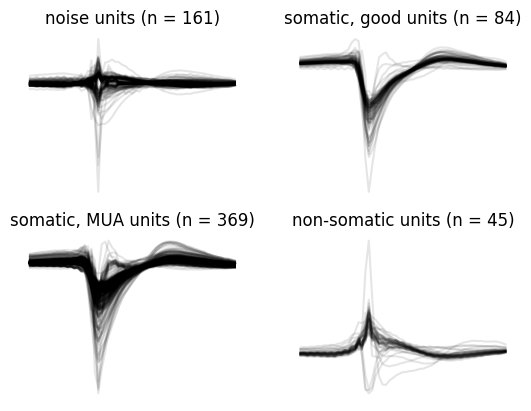

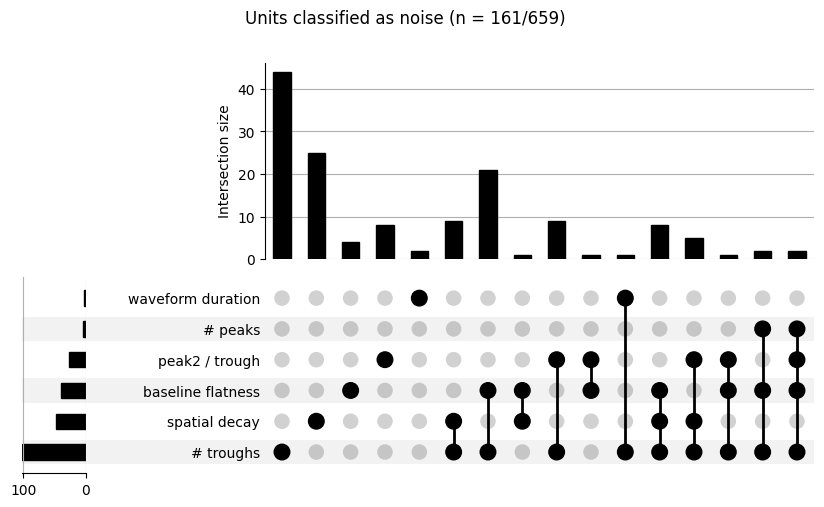

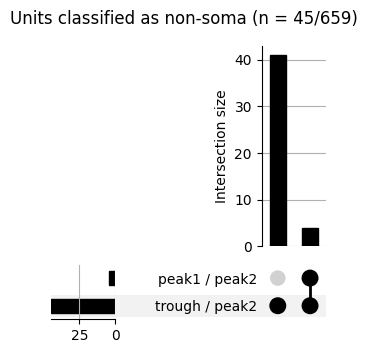

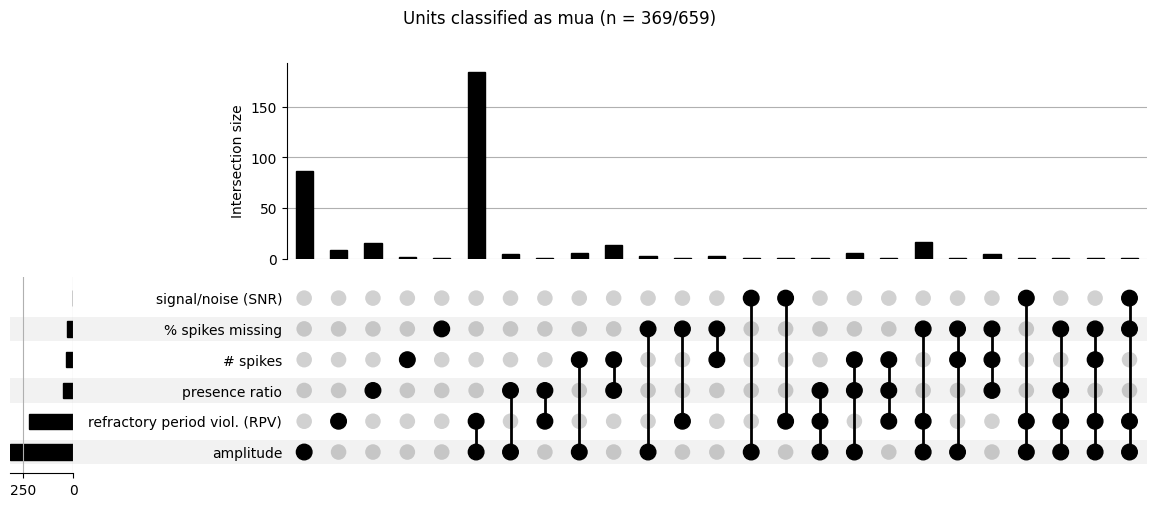

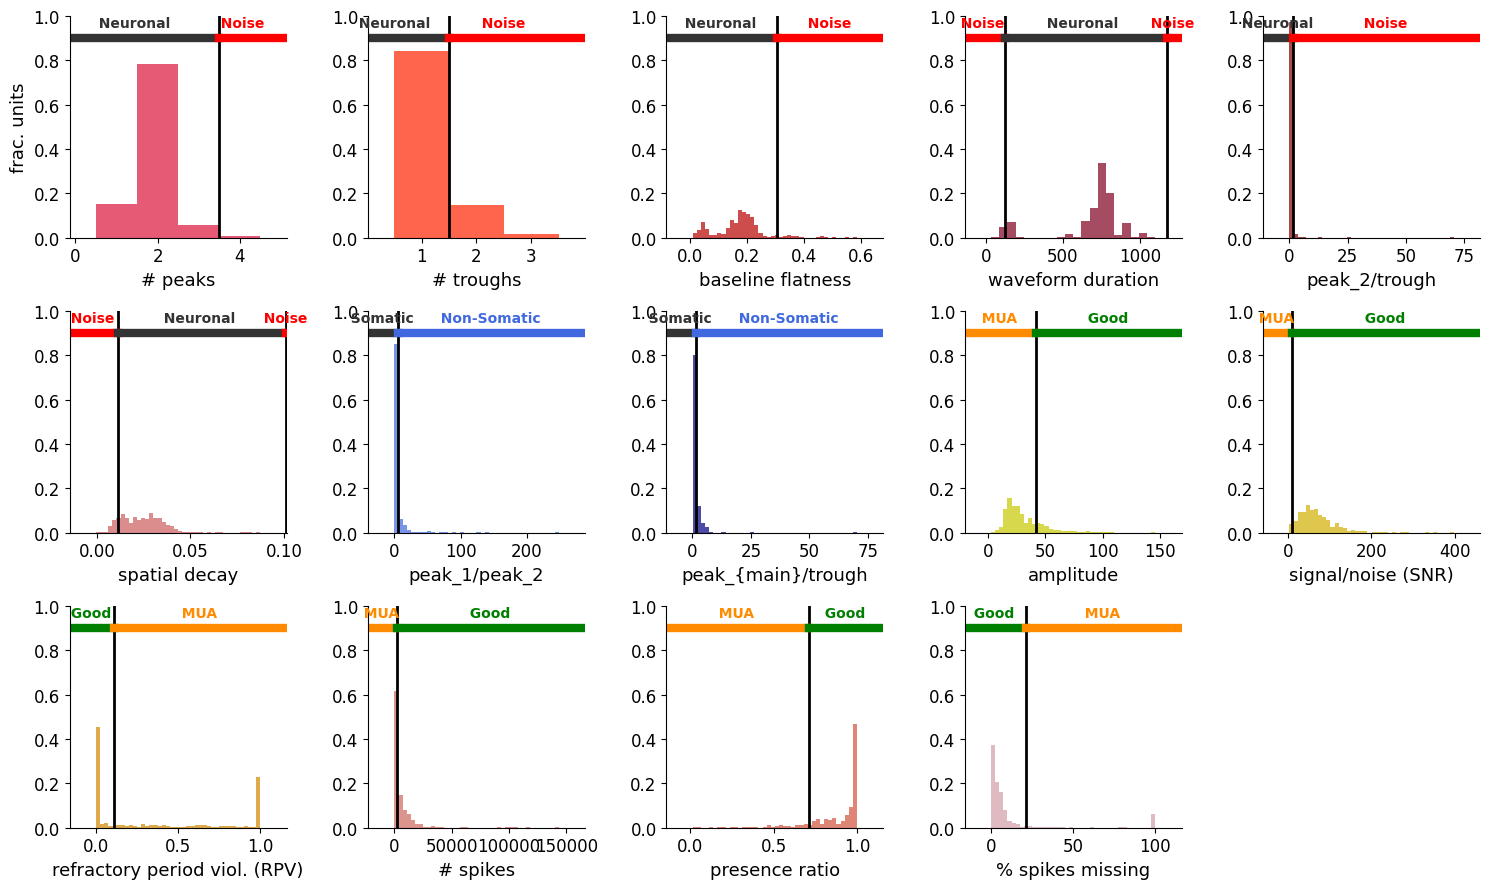

In [15]:
# Example: how to tweak a classification threshold and replot the summary plots 

# load previously computed quality metrics
param, quality_metrics, fractions_RPVs_all_taur = bc.load_bc_results(save_path)
# change parameter of interest 
param["maxNPeaks"] = 3 # for instance, it you more atypical waveform shapes in your region of interest
# get quality unit types
unit_type, unit_type_string = bc.qm.get_quality_unit_type(
        param, quality_metrics
    ) 
# load ephys data
(
    spike_times_samples,
    spike_clusters, # actually spike_templates, but they're the same in bombcell
    template_waveforms,
    template_amplitudes,
    pc_features,
    pc_features_idx,
    channel_positions,
) = bc.load_ephys_data(ks_dir)
# replot global output plots
bc.plot_summary_data(quality_metrics, template_waveforms, unit_type, unit_type_string, param)


# Section 2: Ephys Properties & Cell Classification

In [17]:
# Use the real dataset for ephys properties demonstration
ks_dir = "toy_data"
save_path = Path(ks_dir) / "bombcell"

print(f"Using kilosort directory: {ks_dir}")

Using kilosort directory: toy_data


In [16]:
# Compute ephys properties for cell type classification
ephys_param = bc.get_ephys_parameters(ks_dir)

# Compute all ephys properties - now defaults to ks_dir/bombcell
ephys_properties, ephys_param = bc.run_all_ephys_properties(ks_dir, ephys_param, save_path=save_path)

Computing ephys properties for 659 units ...


Computing ephys properties:   0%|          | 0/659 [00:00<?, ?it/s]

Ephys properties computation complete!
Ephys properties saved to: /home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4/bombcell/templates._bc_ephysProperties.parquet
Parameters saved to: /home/jf5479/cup/Julie/from_Yunchang/20250411_4423_antibody_maze_C1/CatGT_out/catgt_20250411_4423_C1_g0/20250411_4423_C1_g0_imec0/imec0_ks4/bombcell/_bc_ephysParameters.parquet


Classifying striatum neurons...


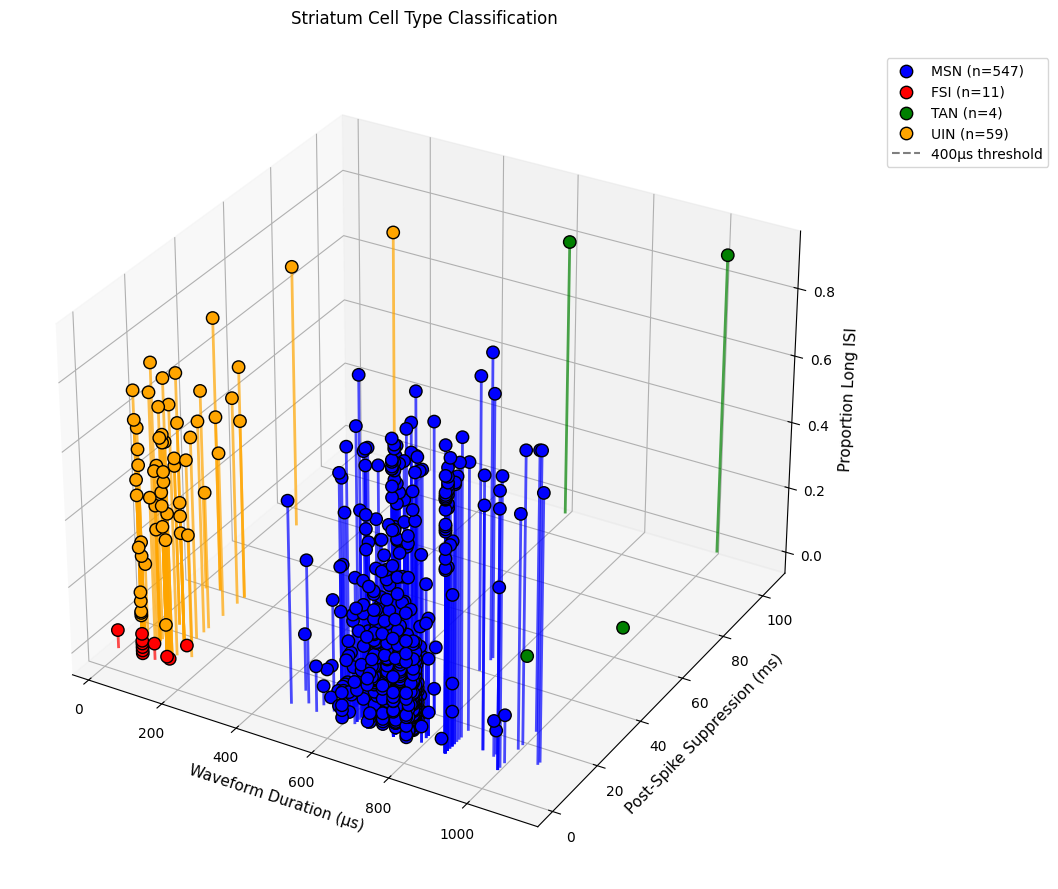

Plotted 621 units:
  Waveform duration range: 33-1100 μs
  Post-spike suppression range: 1.0-104.0 ms
  Prop long ISI range: 0.000-0.902

Striatum cell type distribution:
  MSN: 547 (83.0%)
  FSI: 11 (1.7%)
  TAN: 4 (0.6%)
  UIN: 59 (9.0%)
  Unknown: 38 (5.8%)


In [18]:
# Cell type classification with automatic plot generation
# Specify brain region: 'cortex' or 'striatum'
brain_region = 'striatum'  # Change this to 'cortex' for cortical data. Striatum and cortex are the only two options for now. 

print(f"Classifying {brain_region} neurons...")
cell_types = bc.classify_and_plot_brain_region(ephys_properties, ephys_param, brain_region)

In [19]:
# Show classification results
if cell_types is not None:
    # Create combined results table
    ephys_df = pd.DataFrame(ephys_properties)
    ephys_properties_table = ephys_df.copy()
    ephys_properties_table['cell_type'] = cell_types
   
    print(ephys_properties_table)

     unit_id  postSpikeSuppression  acg_tau_rise  acg_tau_decay    isi_cv  \
0          0              0.904836           0.0     260.752279  4.757316   
1          1              0.702683           0.0            NaN  3.885528   
2          2              0.948073           0.0      88.399703  4.700458   
3          3              0.000000           1.0            NaN  1.720195   
4          4                   NaN           NaN            NaN       NaN   
..       ...                   ...           ...            ...       ...   
654      654              0.000000           0.0            NaN  1.484146   
655      655              0.000000           5.0            NaN  2.055697   
656      656              0.379355           3.0      70.811065  2.797434   
657      657              0.000000           6.0      20.443801  1.721847   
658      658              0.862936           0.0            NaN  2.839811   

      isi_cv2  isi_skewness  prop_long_isi  waveform_duration_peak_trough  